# Exchange Rate Prediction

In [751]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM, InputLayer
from keras.models import Sequential
from keras.callbacks import EarlyStopping

## Utility

In [712]:
def plot_series(series):    
    plt.figure(figsize=(12,6))
    plt.xlabel('Time')
    plt.ylabel('Exchange Rate')
    plt.grid(True)
    plt.plot(series)

## Download Data

In [713]:
end = datetime.now()
start = datetime(end.year-5,end.month,end.day)
currency = "CADCNY=X"
df = yf.download(currency, start,end)

[*********************100%%**********************]  1 of 1 completed


In [714]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-13,5.0724,5.1213,5.0720,5.0728,5.0728,0
2019-05-14,5.0953,5.1149,5.0911,5.0951,5.0951,0
2019-05-15,5.0572,5.1186,5.0572,5.1020,5.1020,0
2019-05-16,5.0683,5.1316,5.0679,5.1084,5.1084,0
2019-05-17,5.1062,5.1405,5.0814,5.1072,5.1072,0


In [715]:
df.drop('Volume', axis=1, inplace=True)

In [716]:
df.shape

(1305, 5)

In [717]:
df.describe()

,Open,High,Low,Close,Adj Close
count,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000
mean,5.181510,5.199678,5.154551,5.183136,5.183136
std,0.116163,0.115258,0.116564,0.115856,0.115856
min,4.860398,4.915445,4.801252,4.872813,4.872813
25%,5.088836,5.106270,5.061405,5.090204,5.090204
50%,5.188094,5.208979,5.159564,5.189989,5.189989
75%,5.264690,5.282016,5.239141,5.266287,5.266287
max,5.496837,5.500776,5.443882,5.496722,5.496722


In [718]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Exchange Rate')

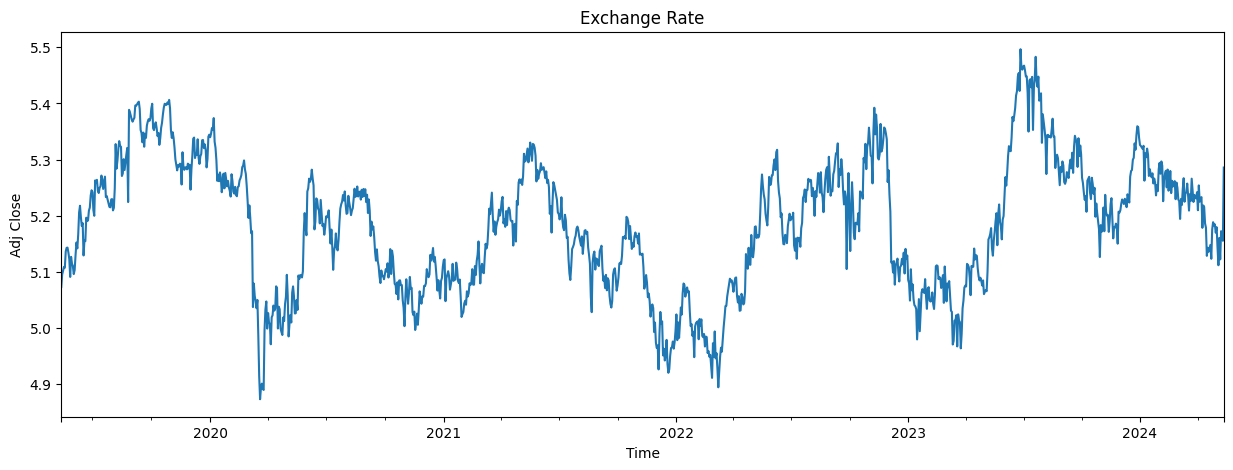

In [719]:
plt.figure(figsize = (15,5))
df['Adj Close'].plot()
plt.xlabel("Time")
plt.ylabel("Adj Close")
plt.title("Exchange Rate")

In [720]:
def plot_graph(figsize, values, column_name):
    plt.figure()
    values.plot(figsize = figsize)
    plt.xlabel("Time")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Exchange Rate")

In [721]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close'], dtype='object')

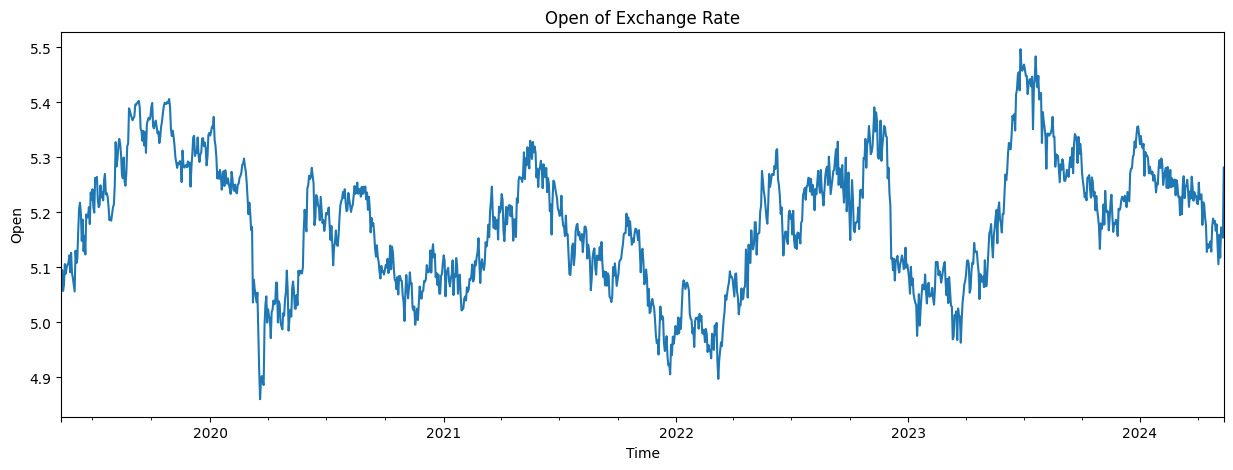

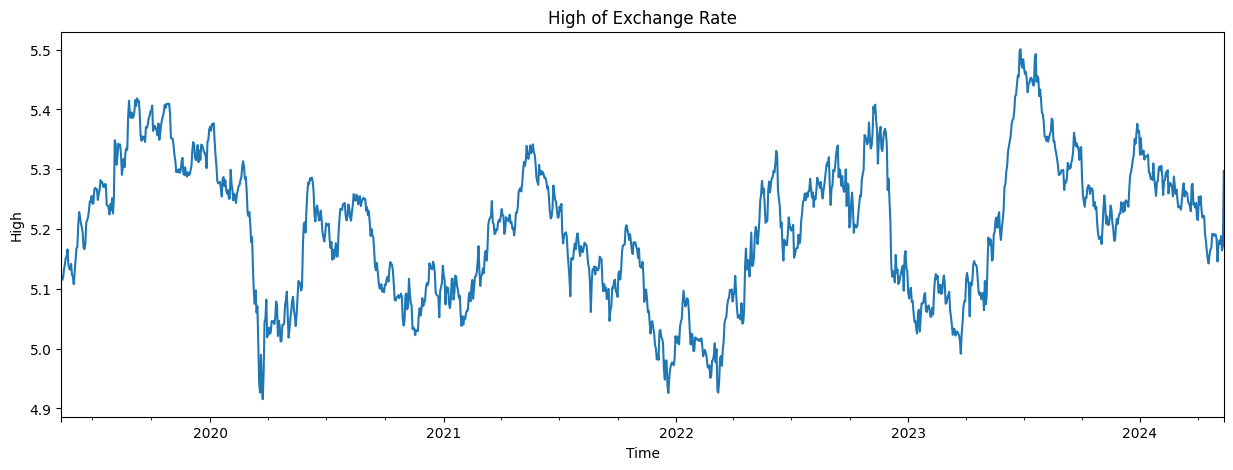

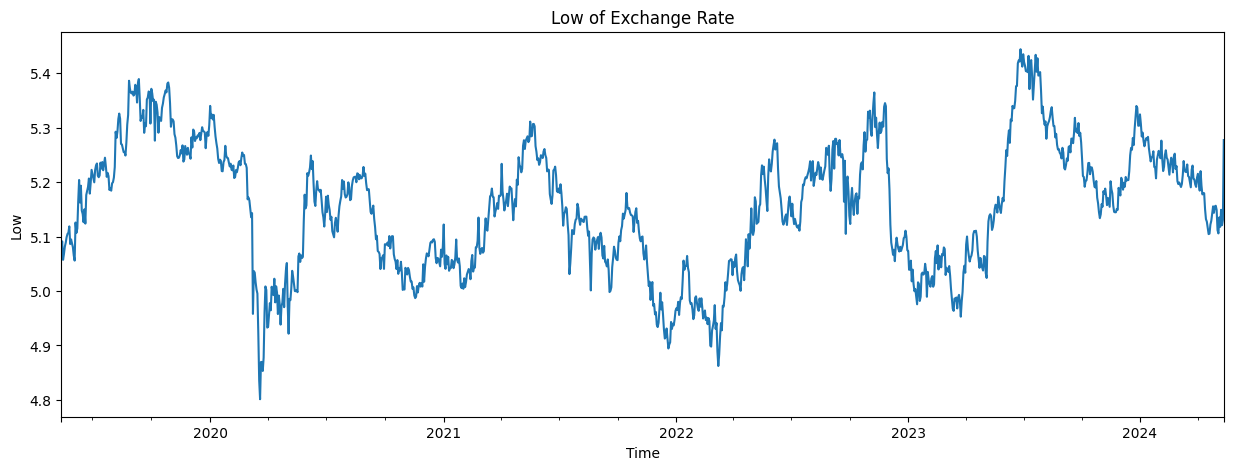

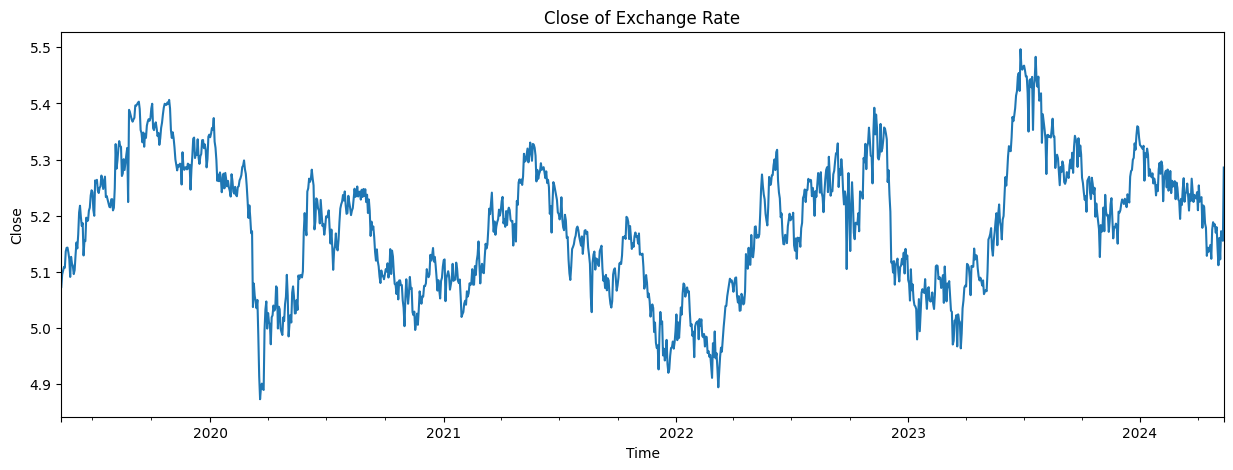

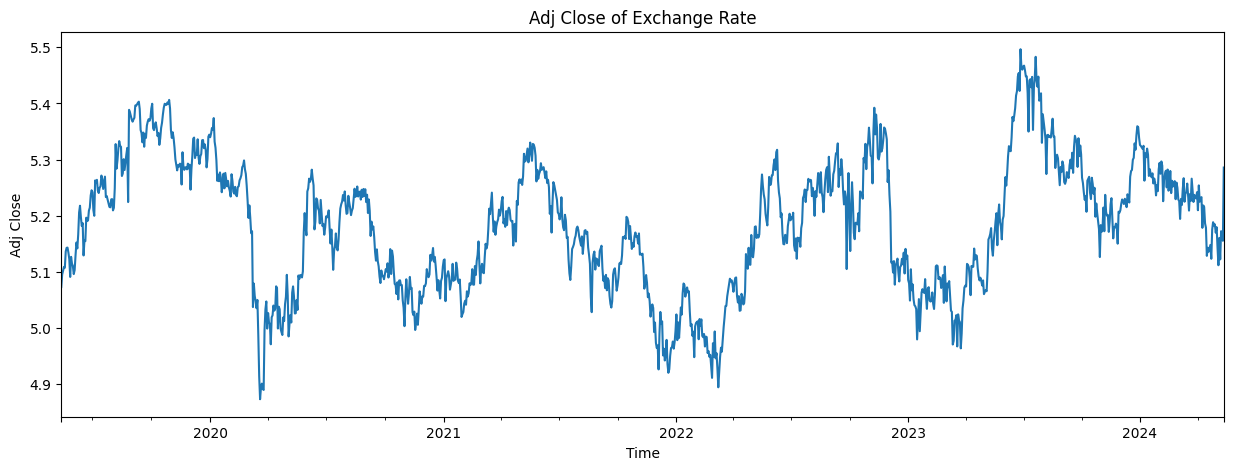

In [722]:
for column in df.columns:
    plot_graph((15,5),df[column], column)

<Figure size 640x480 with 0 Axes>

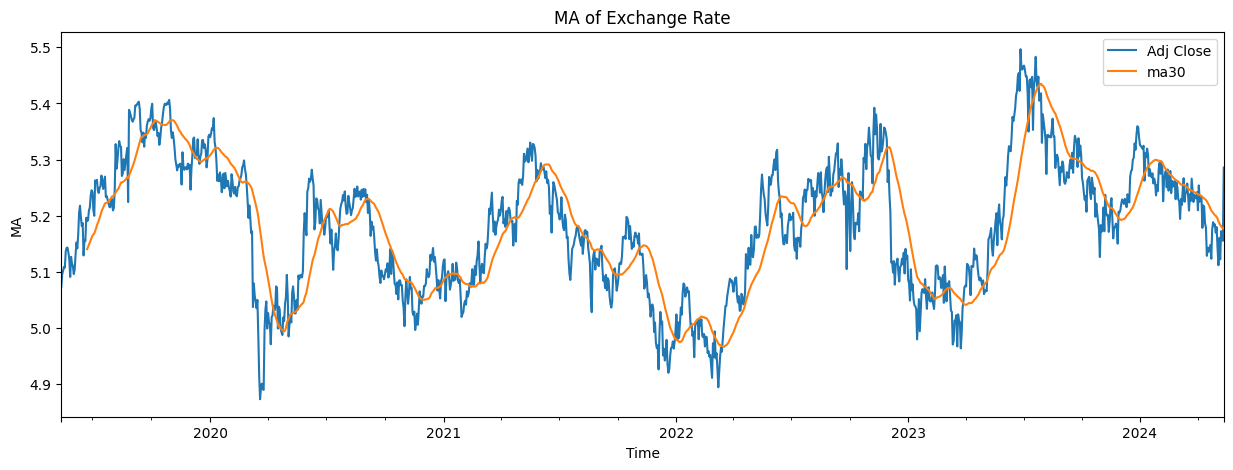

In [723]:
df['ma30']=df['Adj Close'].rolling(30).mean()
plot_graph((15,5), df[['Adj Close','ma30']], 'MA')

In [724]:
df['percentage_change_cp'] = df['Close'].pct_change()
df.head()

,Open,High,Low,Close,Adj Close,ma30,percentage_change_cp
Date,,,,,,,
2019-05-13,5.0724,5.1213,5.0720,5.0728,5.0728,NaN,NaN
2019-05-14,5.0953,5.1149,5.0911,5.0951,5.0951,NaN,0.004396
2019-05-15,5.0572,5.1186,5.0572,5.1020,5.1020,NaN,0.001354
2019-05-16,5.0683,5.1316,5.0679,5.1084,5.1084,NaN,0.001254
2019-05-17,5.1062,5.1405,5.0814,5.1072,5.1072,NaN,-0.000235


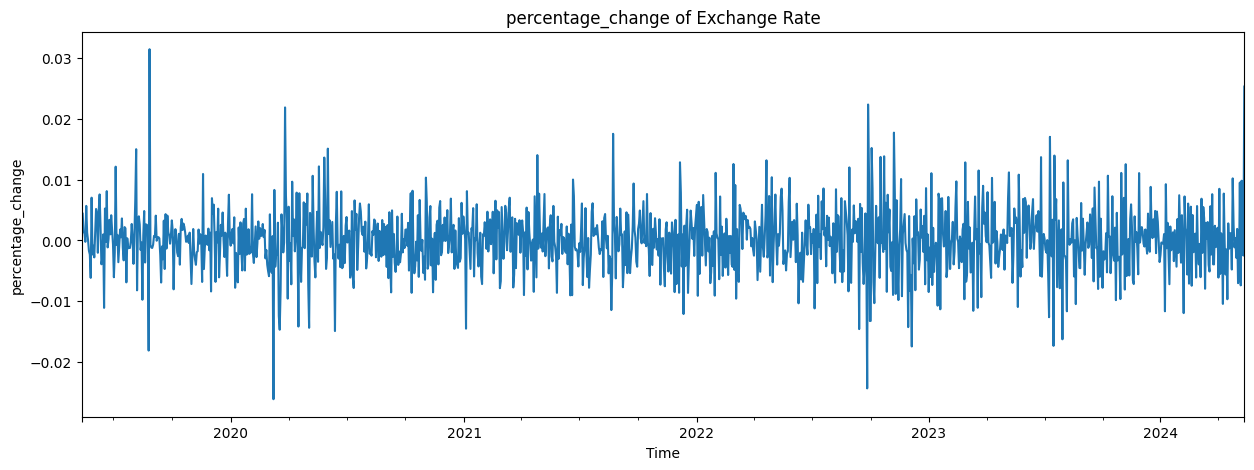

In [725]:
plot_graph((15,5), df['percentage_change_cp'], 'percentage_change')

In [726]:
Adj_close_price = df[['Adj Close']]

In [727]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Adj_close_price)
scaled_data

array([[0.32053863],
       [0.35628065],
       [0.36734045],
       ...,
       [0.47338417],
       [0.45271822],
       [0.66193428]])

In [728]:
max(Adj_close_price.values),min(Adj_close_price.values) 

(array([5.49672222]), array([4.87281322]))

In [729]:
len(scaled_data)

1305

In [730]:
x_data = []
y_data = []
period = 10
for i in range(period, len(scaled_data)):
    x_data.append(scaled_data[i - period: i])
    y_data.append(scaled_data[i])

x_data, y_data = np.array(x_data), np.array(y_data)

In [731]:
x_data[0],y_data[0]

(array([[0.32053863],
        [0.35628065],
        [0.36734045],
        [0.37759777],
        [0.37567485],
        [0.42215568],
        [0.43257426],
        [0.43321472],
        [0.41911081],
        [0.40003684]]),
 array([0.34938843]))

In [732]:
int(len(x_data)*0.7)

906

In [733]:
splitting_len = int(len(x_data)*0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

In [734]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(906, 10, 1)
(906, 1)
(389, 10, 1)
(389, 1)


In [735]:
#ML Model

In [736]:
model = Sequential()
model.add(InputLayer(shape=(x_train.shape[1], 1)))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 32))

model.add(Dense(units = 64))
model.add(Dense(units = 32))
model.add(Dense(units = 10))
model.add(Dense(units = 1))


In [737]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,917 (519.21 KB)

 Trainable params: 132,917 (519.21 KB)

 Non-trainable params: 0 (0.00 B)

In [738]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [755]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=1, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022
Epoch 2/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0021
Epoch 3/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0020
Epoch 4/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0027
Epoch 5/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0021
Epoch 6/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022
Epoch 7/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0021
Epoch 8/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0025
Epoch 9/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0023
Epoch 10/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0020
Epoch 11/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0019
Epoch 12/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0024
Epoch 13/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0021
Epoch 14/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022
Epoch 15/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lo

In [756]:
predictions = model.predict(x_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [757]:
predictions

array([[0.7435201 ],
       [0.68532217],
       [0.65767604],
       [0.65629536],
       [0.722523  ],
       [0.6886295 ],
       [0.69324005],
       [0.69980454],
       [0.72468966],
       [0.7252758 ],
       [0.7203239 ],
       [0.70893884],
       [0.6334698 ],
       [0.6337918 ],
       [0.5683535 ],
       [0.52204335],
       [0.41641682],
       [0.3877073 ],
       [0.35591853],
       [0.3890975 ],
       [0.3408713 ],
       [0.39154136],
       [0.39364302],
       [0.40302157],
       [0.37220335],
       [0.34570765],
       [0.3825548 ],
       [0.38154268],
       [0.39968684],
       [0.38837314],
       [0.41900975],
       [0.3735528 ],
       [0.43528622],
       [0.40499985],
       [0.40915808],
       [0.3572805 ],
       [0.33780277],
       [0.298312  ],
       [0.3867069 ],
       [0.33470333],
       [0.33645207],
       [0.30610135],
       [0.28614768],
       [0.28300118],
       [0.2764083 ],
       [0.21962437],
       [0.26073185],
       [0.308

In [758]:
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

array([[5.336702 ],
       [5.3003917],
       [5.283143 ],
       [5.282282 ],
       [5.3236017],
       [5.3024554],
       [5.305332 ],
       [5.3094277],
       [5.3249536],
       [5.325319 ],
       [5.32223  ],
       [5.3151264],
       [5.2680407],
       [5.268242 ],
       [5.2274137],
       [5.1985207],
       [5.1326194],
       [5.114707 ],
       [5.094874 ],
       [5.115575 ],
       [5.085486 ],
       [5.1171   ],
       [5.1184106],
       [5.124262 ],
       [5.1050344],
       [5.088503 ],
       [5.111492 ],
       [5.110861 ],
       [5.1221814],
       [5.1151223],
       [5.134237 ],
       [5.105876 ],
       [5.144392 ],
       [5.1254964],
       [5.128091 ],
       [5.0957236],
       [5.083572 ],
       [5.0589323],
       [5.114083 ],
       [5.081638 ],
       [5.0827284],
       [5.0637927],
       [5.051343 ],
       [5.0493803],
       [5.045267 ],
       [5.009839 ],
       [5.035486 ],
       [5.0654182],
       [5.0275273],
       [5.042427 ],


In [759]:
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[5.30369377],
       [5.30013895],
       [5.30991697],
       [5.36354685],
       [5.31426907],
       [5.31990385],
       [5.33405876],
       [5.35717106],
       [5.35495186],
       [5.34660387],
       [5.33607578],
       [5.25991297],
       [5.28100395],
       [5.23704576],
       [5.20727301],
       [5.11635208],
       [5.11796379],
       [5.09871817],
       [5.1190238 ],
       [5.07705212],
       [5.11134291],
       [5.11647606],
       [5.12344599],
       [5.09880686],
       [5.08272982],
       [5.10857916],
       [5.1109972 ],
       [5.12307787],
       [5.1133852 ],
       [5.134058  ],
       [5.09696007],
       [5.14080477],
       [5.1239872 ],
       [5.12895918],
       [5.08537292],
       [5.07932711],
       [5.04864979],
       [5.10448694],
       [5.06699419],
       [5.07745504],
       [5.05111504],
       [5.04046202],
       [5.03850317],
       [5.03347588],
       [4.97939491],
       [5.01769209],
       [5.05128288],
       [4.993

In [760]:
rmse = np.sqrt(np.mean( (inv_predictions - inv_y_test)**2))

In [761]:
rmse

0.03167494211968568

In [762]:
ploting_data = pd.DataFrame(
 {
  'original_test_data': inv_y_test.reshape(-1),
    'predictions': inv_predictions.reshape(-1)
 } ,
    index = df.index[splitting_len+period:]
)
ploting_data.head()

,original_test_data,predictions
Date,,
2022-11-15,5.303694,5.336702
2022-11-16,5.300139,5.300392
2022-11-17,5.309917,5.283143
2022-11-18,5.363547,5.282282
2022-11-21,5.314269,5.323602


<Figure size 640x480 with 0 Axes>

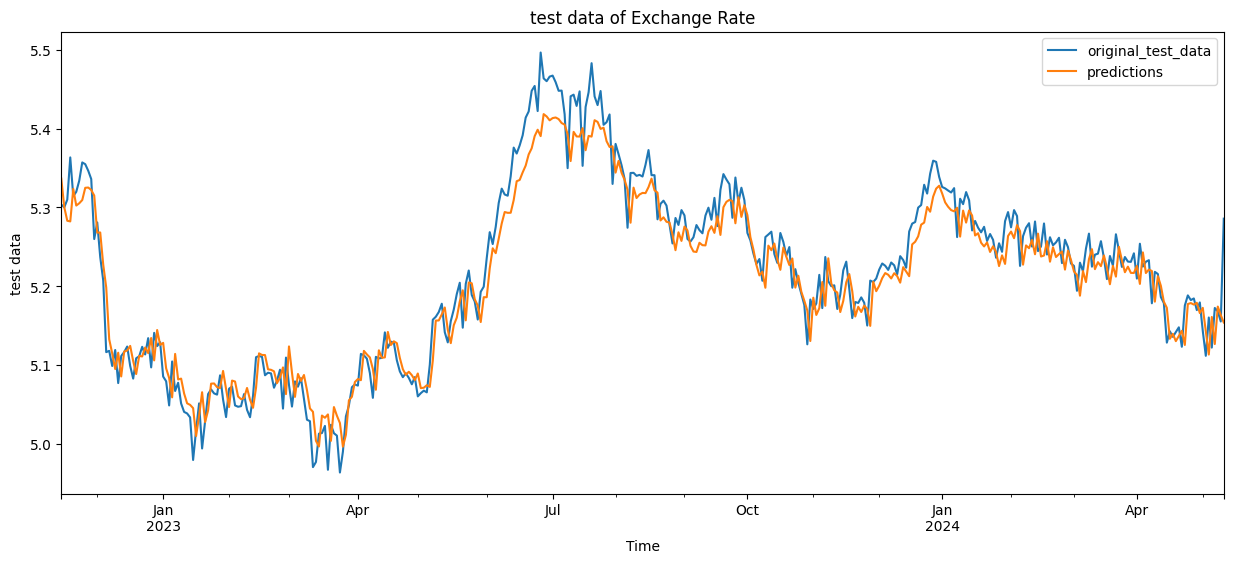

In [763]:
plot_graph((15,6), ploting_data, 'test data')

<Figure size 640x480 with 0 Axes>

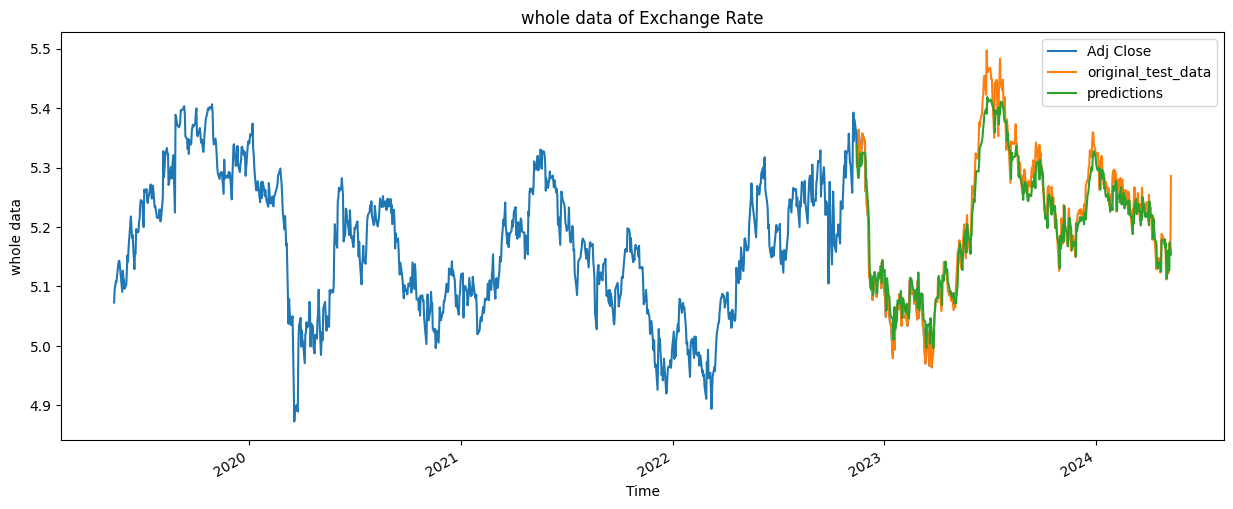

In [764]:
plot_graph((15,6), pd.concat([Adj_close_price[:splitting_len+100],ploting_data], axis=0), 'whole data')

In [765]:
model.save("exchange_rate_predict_model.keras")